In this notebook, I detail the method by which a grid is generated and subsequently filled.

In [123]:
import pickle
import numpy as np
import torch

WEEKDAY_GRID_SIZE = 15

In [124]:
#  if a square is empty, 0.  If a square is black, 1.
def bin_gridify(raw_grids):
    binary_grids = []
    for grid in raw_grids:
        new_grid = [1 if x == "." else 0 for x in grid ]
        binary_grids = binary_grids + [new_grid]
    return binary_grids


In [125]:
dow_dict = pickle.load(open('../bin/pickles/dow_dict.pickle','rb'))

In [126]:
data_set = []
for day in dow_dict.keys():
    grid_list = dow_dict[day]
    grid_list = bin_gridify(grid_list)
    data_set = data_set + [grid_list]

In [127]:
import matplotlib.pyplot as plt

mon = data_set[0]
mon = [np.array(grid).reshape(15,15) for grid in mon if len(grid) == (15*15)]

tue = data_set[1]
tue = [np.array(grid).reshape(15,15) for grid in tue if len(grid) == (15*15)]

In [128]:
# defining a function that checks the symmetry of the grid
def check_symmetry(dim,grid):
    leng = dim*dim
    half = (leng-1)//2
    array = grid.reshape(leng,)
    front = array[:half]
    back = array[-half:]
    return (front == np.flip(back)).all()

In [129]:
check_symmetry(15,mon[0])

True

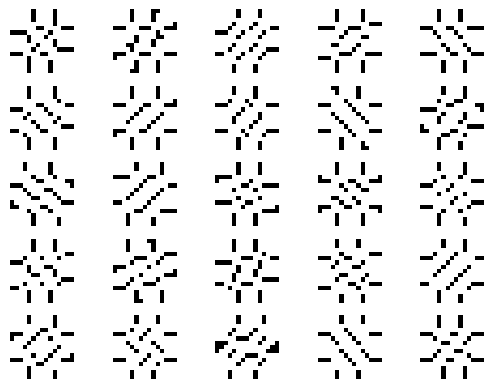

In [130]:
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(mon[i],cmap="Greys")
plt.show()

In [131]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
print("PyTorch version is:",torch.__version__)
print("Torchvision version is:",torchvision.__version__)


PyTorch version is: 1.12.1.post200
Torchvision version is: 0.13.1


In [149]:
num_workers = 32 #
batch_size = 64 # number of samples per batch
# transform = transforms.ToTensor()
train_data = np.array(mon+tue)
train_data_tensor = torch.from_numpy(train_data)
labels = np.array([1]*len(train_data))

# creating a loader to feed the models training data
train_me = torch.utils.data.DataLoader(train_data_tensor, batch_size=batch_size,num_workers=0)

In [150]:
train_demo = iter(train_me)
images, *_ = train_demo.next()
img = np.squeeze(images[0:15])
fig = plt.imshow(img,cmap='Greys',aspect=True)
# images.shape

TypeError: 'type' object is not iterable

## Creating custom class for the grid dataset in pytorch

In [156]:
import os
import pandas as pd
from torch.utils.data import Dataset

class GridDataset(Dataset):
    def __init__(self,annotations_file,train_grids,transform=None, target_transform=None):
        self.grid_labels = np.array([1]*len(train_grids))
        self.grid_array = train_grids
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.grid_labels)

    def __getitem__(self,idx):
        grid = self.grid_array.iloc[idx]
        label = self.grid_labels.iloc[idx]


        if self.transform:
            image = self.transform(grid)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [134]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self,input_size,hidden_dim,output_size):
        super(Discriminator,self).__init__()

        # 3 hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2,hidden_dim)

        # output layer
        self.fc4 = nn.Linear(hidden_dim,output_size)

        # defining a dropout layer to prevent overfitting.
        self.dropout= nn.Dropout(0.2)

    def forward (self,x):
        x = x.view(-1,28*28)
        x = F.leaky_relu(self.fc1(x),0.2) # input
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        # return result of output layer
        return self.fc4(x)


In [135]:
# Defining a generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
         super(Generator, self).__init__()

         # Defining all hidden layers for the generator
         self.fc1 = nn.Linear(input_size, hidden_dim)
         self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
         self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

         # Defining the output layer for the generator
         self.fc4 = nn.Linear(hidden_dim*4, output_size)

         # defining the droput for the generator, which prevents overfitting.
         self.dropout = nn.Dropout(0.3)
    def forward(self, x):
         # creating all hidden layers
         x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
         x = self.dropout(x) # dropout to reduce overfit
         x = F.leaky_relu(self.fc2(x), 0.2)
         x = self.dropout(x)
         x = F.leaky_relu(self.fc3(x), 0.2)
         x = self.dropout(x)

         # return result of the output layer
         return F.tanh(self.fc4(x))


## Defining initial hyperparameters:

In [136]:
# discriminator
# size of the input grid
input_size = WEEKDAY_GRID_SIZE ** 2
# discriminator outputs either 1 or 0 depending on whether it sees a real or fake grid
discriminator_out_size = 1
# size of final hidden layer in discriminator
discriminator_hidden_size = 64

# generator
# size of the latent vector that is being passed to the generator
latent_vector_dim = 100
# size of the generator's output
generator_out_size = input_size
# size of the first hidden layer in the generator
generator_hidden_size = 64


## Creating the GAN:

In [137]:
# initializing the Gan with the above hyperparameters
discriminator = Discriminator(input_size,discriminator_hidden_size,discriminator_out_size)
generator = Generator(latent_vector_dim,generator_hidden_size,generator_out_size)

In [138]:
print("The Discriminator: \n",discriminator)
print("The Generator: \n", generator)

The Discriminator: 
 Discriminator(
  (fc1): Linear(in_features=225, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
The Generator: 
 Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=225, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Defining Loss functions

In [139]:
# Calculating loss for the Discriminator
def discriminator_loss(disc_out, smooth=False):
    batch_size = disc_out.size(0)
    if smooth:
        # labels multiplied by 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    loss = nn.BCEWithLogitsLoss()
    return loss(disc_out.squeeze(),labels)


def generator_loss(disc_out):
    batch_size = disc_out.size(0)
    labels = torch.zeros(batch_size)
    loss = nn.BCEWithLogitsLoss()
    return loss(disc_out.squeeze(),labels)

## Defining optimizers:


In [140]:
from torch.optim import Adam

learning_rate = 0.002
discriminator_opt = Adam(discriminator.parameters(),learning_rate)
generator_opt = Adam(generator.parameters(),learning_rate)

## Training the models

In [141]:
import pickle as pkl

# parameters for training
num_epochs = 100

# list of sample set and fake set
sample_list = []
loss_list = []

print_every = 400

# generate some fixed data that can be used to benchmark the model throughout training
sample_size = 32
fixed_data = np.random.uniform(-1,1,size=(sample_size,latent_vector_dim))
fixed_data = torch.from_numpy(fixed_data).float()

In [153]:
# Training time!
discriminator.train()
generator.train()
train_loader = torch.utils.data.DataLoader(train_data_tensor, batch_size=batch_size,num_workers=0,sampler=enumerate,generator=1738,drop_last=True)

for epoch in range(num_epochs):
    for b_index, (real_grids,_) in enumerate(train_me):

        # get batch size from size of real_grids
        batch_size = real_grids.size(0)

        real_grids = real_grids*2-1 # rescale input images from [0,1] to [-1,1]

        # DISC Training
        discriminator_opt.zero_grad()

        # first, train on real images
        disc_real = discriminator(real_grids)
        disc_real_loss = discriminator_loss(disc_real,smooth=False)

        # next, to train on fake images
        # start by generating fake images
        fake_grid_input = np.random.binomial(1,p=0.4,size=(batch_size,WEEKDAY_GRID_SIZE,WEEKDAY_GRID_SIZE))
        fake_grid_input = fake_grid_input*2-1
        fake_grid_input = torch.from_numpy(fake_grids)
        fake_grids = generator(fake_grid_input)

        # Compute the disc loss on the fake images
        disc_fake = discriminator(fake_grids)
        disc_fake_loss = generator_loss(disc_fake)

        # sum the losses
        disc_loss = disc_real_loss + disc_fake_loss

        # backpropagation
        disc_loss.backward()
        discriminator_opt.step()


        ### Generator Training
        generator_opt.zero_grad()

        # train on fake images with flipped labels
        # first, generate fake images
        fake_grid_input = np.random.binomial(1,p=0.4,size=(batch_size,WEEKDAY_GRID_SIZE,WEEKDAY_GRID_SIZE))
        fake_grid_input = fake_grid_input*2-1
        fake_grid_input = torch.from_numpy(fake_grid_input)
        fake_grids = generator(fake_grid_input)

        # compute the discriminator losses on fake images, and flip the labels by using the disc_loss function
        disc_fake = discriminator(fake_grids)
        gen_loss = disc_loss(disc_fake)

        # backpropagation
        gen_loss.backward()
        generator_opt.step()

        # Log progress to stdout
        if b_index % print_every==0:

            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, num_epochs,
                                                                                   disc_loss.item(), gen_loss.item()))

    ## Append discriminator loss and gen loss after each epoch
    loss_list.append((disc_loss.item(),gen_loss.item()))

    # generate images with generator and save image
    # set generator in eval mode
    generator.eval()

    #generate samples
    new_samples = generator(fixed_data)
    sample_list.append(new_samples)

    # print the image
    for i in range(32):
        plt.subplot(8,4,1+i)
        plt.axis('off')
        plt.imshow(mon[i],cmap="Greys")
    plt.savefig(f'../exports/gridgan-images/generation_{str.zfill(epoch())}.png',)

    # return generator to training mode
    generator.train()

    with open('../bin/train_samples.pickle','wb') as f:
        pkl.dump(sample_list,f)

    with open('../bin/gan_model_tuple.pickle','wb') as f:
        pkl.dump((discriminator,generator),f)

TypeError: 'type' object is not iterable

In [145]:
(a,b) = enumerate(train_me)

ValueError: too many values to unpack (expected 2)

In [155]:
train_me.